In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import ast

import seaborn as sns
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [5]:
battery_df = pd.read_csv("clean_df.csv")

In [6]:
battery_df.head()

,Unnamed: 0,Name,Extracted_name,Capacity,Conductivity,Coulombic Efficiency,Energy,Voltage,parsed_name,elements_cnt,...,Te_fraction,Ir_fraction,Cr_fraction,Ba_fraction,Cs_fraction,La_fraction,As_fraction,Am_fraction,Fe_fraction,Au_fraction
0,14,( 90PEO:10Zn(CF3SO3)2 ) + 5 ZnO,"[{'C': '2.0', 'F': '6.0', 'S': '2.0', 'O': '6....",NaN,0.000018,NaN,NaN,NaN,"[{'C': '2.0', 'F': '6.0', 'S': '2.0', 'O': '6....",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36,"(5,5′-bisphenylethynyl-2,2′-bipyridyl)Re(CO)3Cl","[{'C': '3.0', 'O': '3.0', 'Re': '1.0', 'Cl': '...",NaN,NaN,NaN,NaN,1.95,"[{'C': '3.0', 'O': '3.0', 'Re': '1.0', 'Cl': '...",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39,(BaCa)(ZrTi)O3,"[{'Ba': '1.0', 'Ca': '1.0', 'Zr': '1.0', 'Ti':...",NaN,NaN,NaN,NaN,3.20,"[{'Ba': '1.0', 'Ca': '1.0', 'Zr': '1.0', 'Ti':...",1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40,(BiO)2CO3,"[{'Bi': '2.0', 'O': '5.0', 'C': '1.0'}]",NaN,NaN,37.5,732.865792,NaN,"[{'Bi': '2.0', 'O': '5.0', 'C': '1.0'}]",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42,(BiO)4CO3(OH)2,"[{'Bi': '4.0', 'O': '9.0', 'H': '2.0', 'C': '1...",210.0,NaN,NaN,NaN,1.10,"[{'Bi': '4.0', 'O': '9.0', 'H': '2.0', 'C': '1...",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
column_list = list(battery_df.columns)
print(column_list)

['Unnamed: 0', 'Name', 'Extracted_name', 'Capacity', 'Conductivity', 'Coulombic Efficiency', 'Energy', 'Voltage', 'parsed_name', 'elements_cnt', 'Capacity_known', 'Conductivity_known', 'Coulombic Efficiency_known', 'Energy_known', 'Voltage_known', 'Pd_fraction', 'S_fraction', 'Na_fraction', 'Ru_fraction', 'Zr_fraction', 'Cn_fraction', 'Hg_fraction', 'Be_fraction', 'Rb_fraction', 'Si_fraction', 'Ra_fraction', 'Sg_fraction', 'Sc_fraction', 'Mn_fraction', 'Pr_fraction', 'Cl_fraction', 'Co_fraction', 'Br_fraction', 'Ac_fraction', 'Ta_fraction', 'Ni_fraction', 'Cu_fraction', 'O_fraction', 'Al_fraction', 'Ho_fraction', 'Th_fraction', 'Hs_fraction', 'Tl_fraction', 'K_fraction', 'Sm_fraction', 'Np_fraction', 'W_fraction', 'Ga_fraction', 'In_fraction', 'Ar_fraction', 'Yb_fraction', 'Rh_fraction', 'Bi_fraction', 'Eu_fraction', 'Pb_fraction', 'Mo_fraction', 'Er_fraction', 'Re_fraction', 'B_fraction', 'Mg_fraction', 'Cd_fraction', 'Cm_fraction', 'Sr_fraction', 'Se_fraction', 'Rf_fraction', 'Li_fra

Explore relationships between datasets

In [11]:

df = pd.read_csv('clean_df.csv')

# Extract element fraction columns
element_cols = [col for col in df.columns if '_fraction' in col]

# Analyze available target data
target_vars = ['Capacity', 'Conductivity', 'Coulombic Efficiency', 'Energy', 'Voltage']

# Create a correlation matrix for available data (element fractions vs. targets)
# First, let's create a dataframe with only the columns we're interested in
analysis_df = df[element_cols + target_vars].copy()

# Let's look at the distributions of target variables where available
plt.figure(figsize=(15, 10))
for i, target in enumerate(target_vars):
    plt.subplot(2, 3, i+1)
    plt.hist(df[target].dropna(), bins=20)
    plt.title(f'Distribution of {target}')
    plt.xlabel(target)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('target_distributions.png')  # Save the figure to view later
plt.close()

# Calculate correlation between elements and targets where data is available
# We'll handle NaNs by using only available data for each correlation
correlation_results = {}
for target in target_vars:
    # Get correlation for each element with the target
    valid_data = df[~df[target].isna()]
    if len(valid_data) > 0:  # Only if we have some data
        correlations = []
        for elem in element_cols:
            if valid_data[elem].nunique() > 1:  # Only if the element has variation
                corr = np.corrcoef(valid_data[elem], valid_data[target])[0, 1]
                correlations.append((elem, corr))
        # Sort by absolute correlation
        correlations.sort(key=lambda x: abs(x[1]), reverse=True)
        correlation_results[target] = correlations[:10]  # Top 10 correlations

# Print the top correlating elements for each target
for target, correlations in correlation_results.items():
    print(f"\nTop elements correlated with {target}:")
    for elem, corr in correlations:
        print(f"{elem}: {corr:.4f}")

# Check if target variables are related to each other
# Create a correlation matrix for target variables
valid_targets = df[target_vars].dropna(how='all')
if len(valid_targets) > 0:
    target_corr = valid_targets.corr()
    print("\nCorrelation between target variables:")
    print(target_corr)

# Count number of elements in each compound
df['element_count'] = df[element_cols].sum(axis=1)
print("\nElement count statistics:")
print(df['element_count'].describe())

# Print the number of compounds with each element count
element_count_dist = df['element_count'].value_counts().sort_index()
print("\nDistribution of number of elements per compound:")
print(element_count_dist)


Top elements correlated with Capacity:
P_fraction: -0.1083
Sc_fraction: 0.0760
Cd_fraction: 0.0742
Zn_fraction: 0.0741
Ge_fraction: 0.0630
C_fraction: -0.0610
Ti_fraction: -0.0557
Zr_fraction: -0.0539
Be_fraction: 0.0527
K_fraction: -0.0493

Top elements correlated with Conductivity:
B_fraction: 0.1411
In_fraction: 0.1353
Dy_fraction: 0.1351
Sb_fraction: 0.1203
F_fraction: 0.0904
Cl_fraction: 0.0787
V_fraction: 0.0721
U_fraction: 0.0660
Ce_fraction: 0.0636
Te_fraction: -0.0594

Top elements correlated with Coulombic Efficiency:
Al_fraction: -0.2123
O_fraction: -0.1362
Ti_fraction: -0.1348
Fe_fraction: -0.1338
B_fraction: 0.1155
Cs_fraction: -0.1135
Sb_fraction: -0.1066
Pb_fraction: -0.1048
Na_fraction: 0.0955
Cu_fraction: 0.0927

Top elements correlated with Energy:
Pt_fraction: 0.1528
Ru_fraction: 0.1257
Ti_fraction: -0.1170
Na_fraction: -0.0921
Pd_fraction: 0.0907
W_fraction: -0.0675
K_fraction: -0.0642
Li_fraction: 0.0631
Te_fraction: 0.0628
Pb_fraction: 0.0619

Top elements correl

The correlations between elemental compositions and target properties are relatively weak, with the strongest correlation being about -0.21 between Al_fraction and Coulombic Efficiency. This suggests we'll need to rely heavily on feature engineering to improve predictive power.

There are notable correlations between some target variables themselves - particularly Capacity and Energy (0.41), and Capacity and Voltage (-0.37). This indicates that these properties are somewhat related, which makes sense from a materials science perspective.
The element count statistics show some unusual values, including negative numbers and extremely large values (up to 10 million), which suggests potential data quality issues


the data and handle the unusual element count values

Add physicochemical properties to enhance our feature set

Design a multi-target neural network architecture

Implement data preprocessing and training

Data cleaning and feature engineering:

In [13]:


# Clean up element fractions (fix negative values, cap extremely large values)
element_cols = [col for col in df.columns if '_fraction' in col]
for col in element_cols:
    # Replace negative values with 0
    df.loc[df[col] < 0, col] = 0
    # Cap extremely large values at 1 (since these are fractions)
    df.loc[df[col] > 1, col] = 1

# Recalculate element count
df['element_count'] = df[element_cols].sum(axis=1)

# Define target variables
target_vars = ['Capacity', 'Conductivity', 'Coulombic Efficiency', 'Energy', 'Voltage']

# Create feature engineering function to add elemental properties
# We'll create a dictionary of elemental properties
# These are just example values - replace with actual values from literature
elemental_properties = {
    'electronegativity': {
        'H': 2.20, 'Li': 0.98, 'Be': 1.57, 'B': 2.04, 'C': 2.55, 'N': 3.04, 'O': 3.44, 'F': 3.98,
        'Na': 0.93, 'Mg': 1.31, 'Al': 1.61, 'Si': 1.90, 'P': 2.19, 'S': 2.58, 'Cl': 3.16,
        'K': 0.82, 'Ca': 1.00, 'Sc': 1.36, 'Ti': 1.54, 'V': 1.63, 'Cr': 1.66, 'Mn': 1.55,
        'Fe': 1.83, 'Co': 1.88, 'Ni': 1.91, 'Cu': 1.90, 'Zn': 1.65, 'Ga': 1.81, 'Ge': 2.01,
        'As': 2.18, 'Se': 2.55, 'Br': 2.96, 'Rb': 0.82, 'Sr': 0.95, 'Y': 1.22, 'Zr': 1.33,
        'Nb': 1.6, 'Mo': 2.16, 'Tc': 1.9, 'Ru': 2.2, 'Rh': 2.28, 'Pd': 2.20, 'Ag': 1.93,
        'Cd': 1.69, 'In': 1.78, 'Sn': 1.96, 'Sb': 2.05, 'Te': 2.1, 'I': 2.66, 'Cs': 0.79,
        'Ba': 0.89, 'La': 1.1, 'Ce': 1.12, 'Pr': 1.13, 'Nd': 1.14, 'Sm': 1.17, 'Eu': 1.2,
        'Gd': 1.2, 'Tb': 1.1, 'Dy': 1.22, 'Ho': 1.23, 'Er': 1.24, 'Tm': 1.25, 'Yb': 1.1,
        'Lu': 1.27, 'Hf': 1.3, 'Ta': 1.5, 'W': 2.36, 'Re': 1.9, 'Os': 2.2, 'Ir': 2.20,
        'Pt': 2.28, 'Au': 2.54, 'Hg': 2.00, 'Tl': 1.62, 'Pb': 2.33, 'Bi': 2.02, 'Po': 2.0,
        'At': 2.2, 'Ra': 0.9, 'Ac': 1.1, 'Th': 1.3, 'Pa': 1.5, 'U': 1.38, 'Np': 1.36, 'Pu': 1.28,
        'Am': 1.13, 'Cm': 1.28, 'Es': 1.3
    },
    'atomic_radius': {
        'H': 25, 'Li': 145, 'Be': 105, 'B': 85, 'C': 70, 'N': 65, 'O': 60, 'F': 50,
        'Na': 180, 'Mg': 150, 'Al': 125, 'Si': 110, 'P': 100, 'S': 100, 'Cl': 100,
        'K': 220, 'Ca': 180, 'Sc': 160, 'Ti': 140, 'V': 135, 'Cr': 140, 'Mn': 140,
        'Fe': 140, 'Co': 135, 'Ni': 135, 'Cu': 135, 'Zn': 135, 'Ga': 130, 'Ge': 125,
        'As': 115, 'Se': 115, 'Br': 115, 'Rb': 235, 'Sr': 200, 'Y': 180, 'Zr': 155,
        'Nb': 145, 'Mo': 145, 'Tc': 135, 'Ru': 130, 'Rh': 135, 'Pd': 140, 'Ag': 160,
        'Cd': 155, 'In': 155, 'Sn': 145, 'Sb': 145, 'Te': 140, 'I': 140, 'Cs': 260,
        'Ba': 215, 'La': 195, 'Ce': 185, 'Pr': 185, 'Nd': 185, 'Sm': 185, 'Eu': 185,
        'Gd': 180, 'Tb': 175, 'Dy': 175, 'Ho': 175, 'Er': 175, 'Tm': 175, 'Yb': 175,
        'Lu': 175, 'Hf': 155, 'Ta': 145, 'W': 135, 'Re': 135, 'Os': 130, 'Ir': 135,
        'Pt': 135, 'Au': 135, 'Hg': 150, 'Tl': 190, 'Pb': 180, 'Bi': 160, 'Po': 190,
        'At': 150, 'Ra': 215, 'Ac': 195, 'Th': 180, 'Pa': 180, 'U': 175, 'Np': 175,
        'Pu': 175, 'Am': 175, 'Cm': 180, 'Es': 180
    },
    'ionization_energy': {
        'H': 1312, 'Li': 520, 'Be': 900, 'B': 801, 'C': 1086, 'N': 1402, 'O': 1314, 'F': 1681,
        'Na': 496, 'Mg': 738, 'Al': 578, 'Si': 787, 'P': 1012, 'S': 1000, 'Cl': 1251,
        'K': 419, 'Ca': 590, 'Sc': 633, 'Ti': 659, 'V': 651, 'Cr': 653, 'Mn': 717,
        'Fe': 759, 'Co': 760, 'Ni': 737, 'Cu': 746, 'Zn': 906, 'Ga': 579, 'Ge': 762,
        'As': 947, 'Se': 941, 'Br': 1140, 'Rb': 403, 'Sr': 550, 'Y': 600, 'Zr': 640,
        'Nb': 652, 'Mo': 684, 'Tc': 702, 'Ru': 710, 'Rh': 720, 'Pd': 805, 'Ag': 731,
        'Cd': 868, 'In': 558, 'Sn': 709, 'Sb': 834, 'Te': 869, 'I': 1008, 'Cs': 376,
        'Ba': 503, 'La': 538, 'Ce': 528, 'Pr': 523, 'Nd': 530, 'Sm': 544, 'Eu': 547,
        'Gd': 592, 'Tb': 564, 'Dy': 573, 'Ho': 581, 'Er': 589, 'Tm': 597, 'Yb': 603,
        'Lu': 524, 'Hf': 659, 'Ta': 761, 'W': 770, 'Re': 760, 'Os': 840, 'Ir': 880,
        'Pt': 870, 'Au': 890, 'Hg': 1007, 'Tl': 589, 'Pb': 716, 'Bi': 703, 'Po': 812,
        'At': 890, 'Ra': 509, 'Ac': 499, 'Th': 587, 'Pa': 568, 'U': 598, 'Np': 605,
        'Pu': 585, 'Am': 578, 'Cm': 581, 'Es': 619
    }
}

# Create weighted average functions for each property
def add_weighted_properties(df, element_cols, elemental_properties):
    # For each property, create a new column with weighted average
    for prop_name, prop_values in elemental_properties.items():
        # Initialize column with zeros
        df[f'avg_{prop_name}'] = 0.0
        
        # For each element
        for element in prop_values.keys():
            # Find corresponding column
            col_name = f'{element}_fraction'
            if col_name in element_cols:
                # Add weighted contribution
                df[f'avg_{prop_name}'] += df[col_name] * prop_values[element]
    
    return df

# Add feature engineering
df = add_weighted_properties(df, element_cols, elemental_properties)

# Calculate additional features
# 1. Diversity of elements - use Shannon entropy
def calculate_shannon_entropy(row, element_cols):
    fractions = [row[col] for col in element_cols]
    # Filter out zeros and normalize
    fractions = [f for f in fractions if f > 0]
    if not fractions:
        return 0
    total = sum(fractions)
    fractions = [f/total for f in fractions]
    return -sum(f * np.log(f) for f in fractions)

df['element_diversity'] = df.apply(lambda row: calculate_shannon_entropy(row, element_cols), axis=1)

# Print the features we've engineered
print("Engineered features:")
engineered_features = ['avg_electronegativity', 'avg_atomic_radius', 'avg_ionization_energy', 'element_diversity', 'element_count']
print(df[engineered_features].describe())

# Check correlations of new features with targets
correlation_results = {}
for target in target_vars:
    # Get correlation for each feature with the target
    valid_data = df[~df[target].isna()]
    if len(valid_data) > 0:  # Only if we have some data
        correlations = []
        for feature in engineered_features:
            corr = np.corrcoef(valid_data[feature], valid_data[target])[0, 1]
            correlations.append((feature, corr))
        correlation_results[target] = correlations

# Print the correlations of engineered features with targets
for target, correlations in correlation_results.items():
    print(f"\nCorrelations with {target}:")
    for feature, corr in correlations:
        print(f"{feature}: {corr:.4f}")

Engineered features:
       avg_electronegativity  avg_atomic_radius  avg_ionization_energy  \
count            3027.000000        3027.000000            3027.000000   
mean                6.810469         339.150975            2883.903865   
std                 2.621334         120.036577            1154.966243   
min                 0.000000           0.000000               0.000000   
25%                 4.770000         255.000000            2012.000000   
50%                 6.610000         330.000000            2709.000000   
75%                 8.220000         415.000000            3533.500000   
max                19.150000        1265.000000            8342.000000   

       element_diversity  element_count  
count        3027.000000    3027.000000  
mean            1.080368       3.092831  
std             0.313351       0.977762  
min            -0.000000       0.000000  
25%             0.693147       2.000000  
50%             1.098612       3.000000  
75%             1.


Training model for Capacity...
Metal device set to: Apple M1


2025-03-13 15:54:11.840984: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  Samples: 1227 train, 307 test
  RMSE: 309.3719
  R²: -0.0757

Training model for Conductivity...


  Samples: 211 train, 53 test
  RMSE: 0.0036
  R²: -0.4053

Training model for Coulombic Efficiency...


  Samples: 201 train, 51 test
  RMSE: 18.9993
  R²: -0.1074

Training model for Energy...


  Samples: 645 train, 162 test
  RMSE: 389.7190
  R²: -0.0854

Training model for Voltage...
  Samples: 1282 train, 321 test
  RMSE: 1.0059
  R²: 0.1456

Top 10 important features for Capacity:
  Si_fraction: 0.599923
  Na_fraction: 0.586346
  F_fraction: 0.495305
  Li_fraction: 0.473988
  Sb_fraction: 0.443446
  avg_atomic_radius: 0.422267
  Ti_fraction: 0.421854
  Mg_fraction: 0.374398
  N_fraction: 0.313747
  avg_ionization_energy: 0.301183

Top 10 important features for Conductivity:
  Ta_fraction: 0.120020
  W_fraction: 0.116655
  Te_fraction: 0.102215
  Sr_fraction: 0.093066
  Ra_fraction: 0.087178
  Th_fraction: 0.087083
  Nb_fraction: 0.086047
  Am_fraction: 0.083321
  C_fraction: 0.082945
  Cl_fraction: 0.079788

Top 10 important features for Coulombic Efficiency:
  Zr_fraction: 0.126041
  Rb_fraction: 0.118489
  Se_fraction: 0.113956
  Rh_fraction: 0.109535
  Sr_fraction: 0.106916
  Sm_fraction: 0.102816
  Ac_fraction: 0.097652
  Ge_fraction: 0.097376
  Cs_fraction: 0.093263


/Users/hritvikjv/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/hritvikjv/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/hritvikjv/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/hritvikjv/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/hritvikjv/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.w

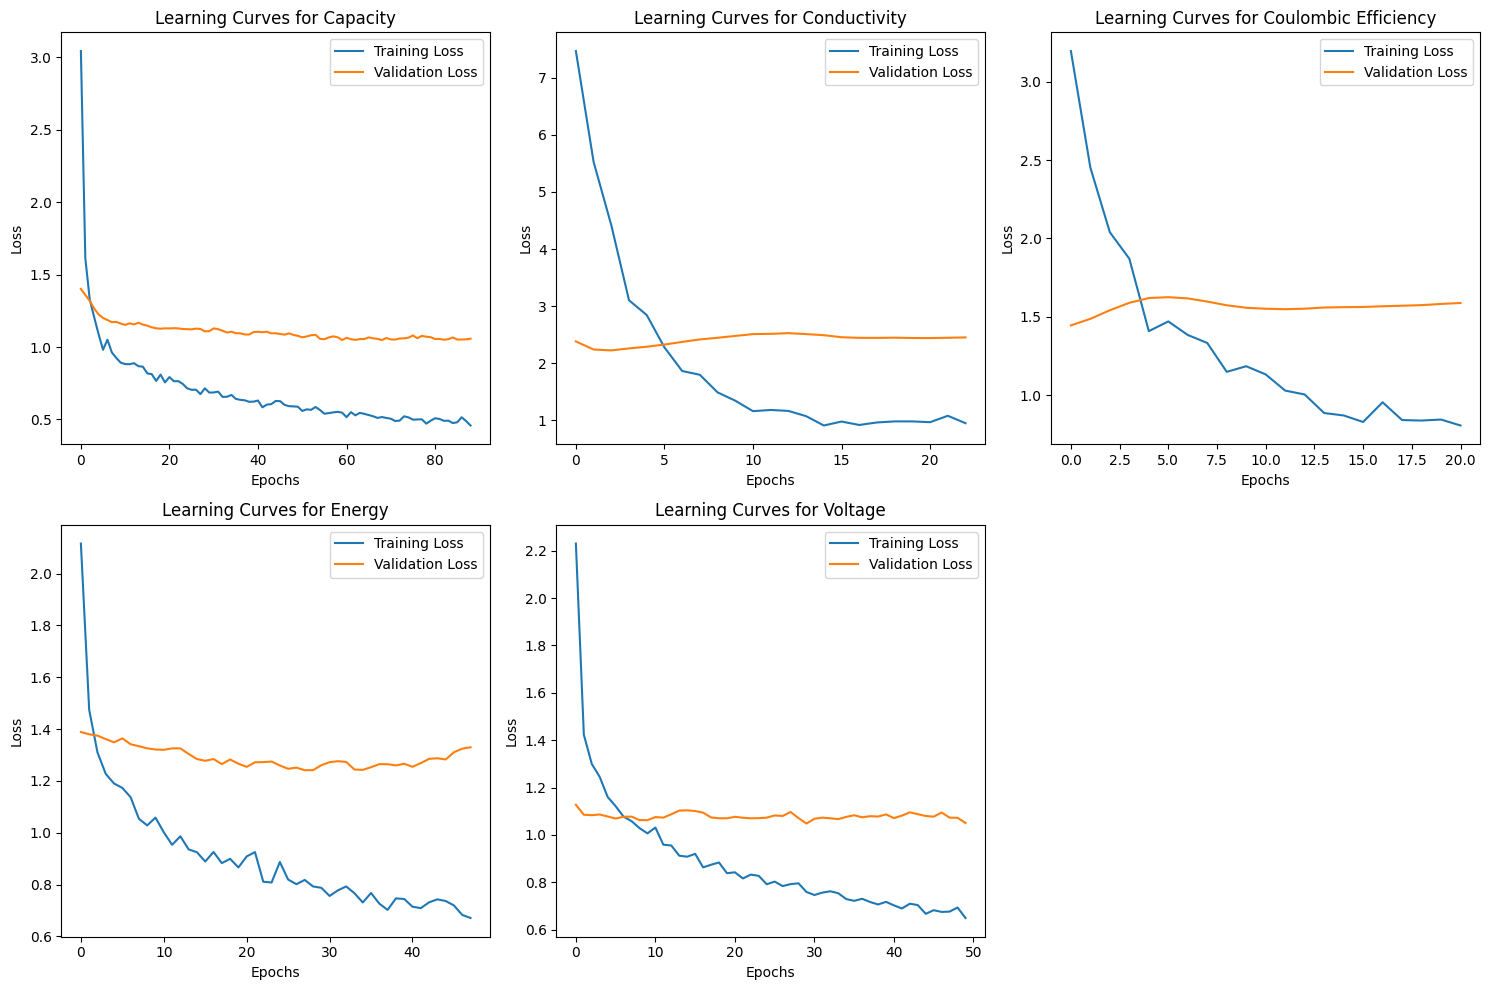

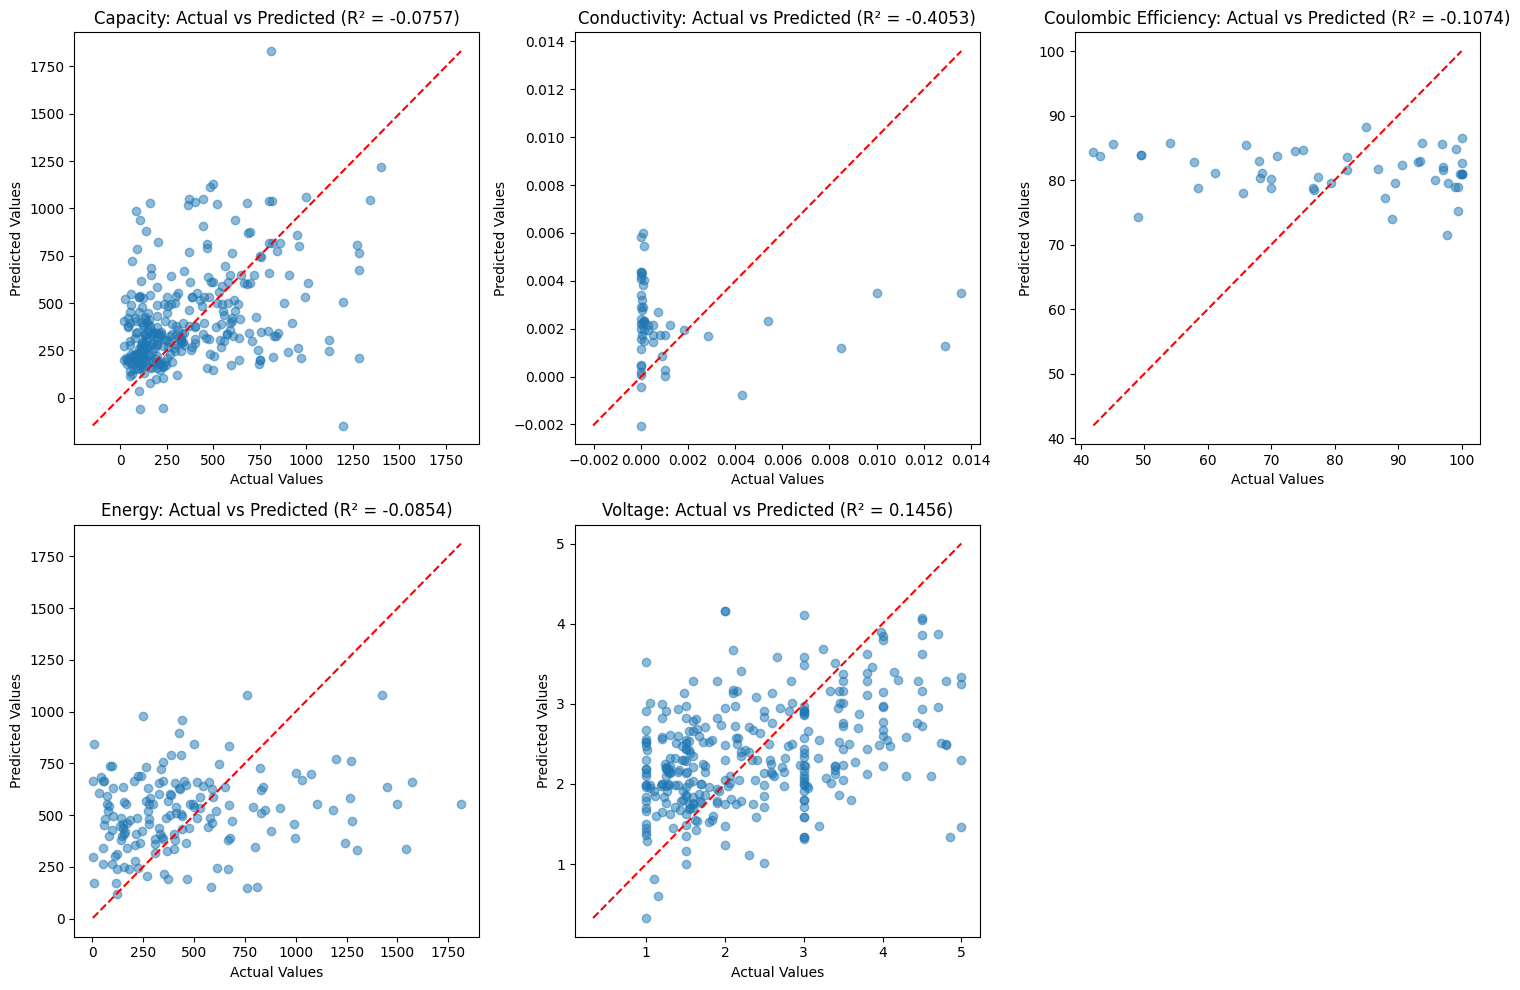

In [15]:
# Define features we'll use
features = element_cols + engineered_features

# Create separate models for each target due to varying sparsity
models = {}
histories = {}
performance_metrics = {}

# Define a function to create and train a model for a single target
def create_train_model(X, y, target_name, test_size=0.2, random_state=42):
    # Get only rows where this target is not null
    valid_indices = ~y.isna()
    X_valid = X[valid_indices]
    y_valid = y[valid_indices]
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_valid, y_valid, test_size=test_size, random_state=random_state
    )
    
    # Scale features and target
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    # Create model
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
    
    # Compile model with a learning rate scheduler
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Define early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_split=0.2,
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Evaluate model
    y_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Create a dictionary with all important outputs
    result = {
        'model': model,
        'history': history,
        'X_scaler': X_scaler,
        'y_scaler': y_scaler,
        'y_test': y_test,
        'y_pred': y_pred,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'train_size': len(X_train),
        'test_size': len(X_test)
    }
    
    return result

# For each target, create and train a model
for target in target_vars:
    print(f"\nTraining model for {target}...")
    result = create_train_model(df[features], df[target], target)
    models[target] = result
    
    # Print performance metrics
    print(f"  Samples: {result['train_size']} train, {result['test_size']} test")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  R²: {result['r2']:.4f}")
    
    # Store results
    performance_metrics[target] = {
        'rmse': result['rmse'],
        'r2': result['r2'],
        'sample_count': result['train_size'] + result['test_size']
    }

# Plot learning curves for each model
plt.figure(figsize=(15, 10))
for i, target in enumerate(target_vars):
    plt.subplot(2, 3, i+1)
    plt.plot(models[target]['history'].history['loss'], label='Training Loss')
    plt.plot(models[target]['history'].history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curves for {target}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.savefig('learning_curves.png')

# Plot actual vs predicted values for each target
plt.figure(figsize=(15, 10))
for i, target in enumerate(target_vars):
    plt.subplot(2, 3, i+1)
    plt.scatter(models[target]['y_test'], models[target]['y_pred'], alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(min(models[target]['y_test']), min(models[target]['y_pred']))
    max_val = max(max(models[target]['y_test']), max(models[target]['y_pred']))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(f'{target}: Actual vs Predicted (R² = {models[target]["r2"]:.4f})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
plt.tight_layout()
plt.savefig('prediction_plots.png')

# Feature importance analysis
def analyze_feature_importance(model, feature_names, target_name):
    # Create a baseline X with all values at their mean
    X_baseline = np.zeros((1, len(feature_names)))
    
    # For each feature, calculate the effect of changing it by 1 std dev
    importances = []
    for i, feature in enumerate(feature_names):
        # Create two copies of the baseline
        X_minus = X_baseline.copy()
        X_plus = X_baseline.copy()
        
        # Modify the feature of interest
        X_minus[0, i] = -1  # -1 std dev
        X_plus[0, i] = 1    # +1 std dev
        
        # Predict
        pred_minus = model.predict(X_minus, verbose=0)[0, 0]
        pred_plus = model.predict(X_plus, verbose=0)[0, 0]
        
        # Calculate importance as the change in prediction
        importance = abs(pred_plus - pred_minus)
        importances.append((feature, importance))
    
    # Sort by importance
    importances.sort(key=lambda x: x[1], reverse=True)
    return importances

# For each target, analyze feature importance
feature_importance = {}
for target in target_vars:
    # Get the model
    model = models[target]['model']
    X_scaler = models[target]['X_scaler']
    
    # Analyze feature importance
    importances = analyze_feature_importance(model, features, target)
    feature_importance[target] = importances
    
    # Print top 10 features
    print(f"\nTop 10 important features for {target}:")
    for feature, importance in importances[:10]:
        print(f"  {feature}: {importance:.6f}")

# Function to make predictions for a new compound
def predict_properties(compound_features, target='all'):
    predictions = {}
    
    # If target is 'all', predict all targets
    if target == 'all':
        targets_to_predict = target_vars
    else:
        targets_to_predict = [target]
    
    for target in targets_to_predict:
        # Get the model and scalers
        model = models[target]['model']
        X_scaler = models[target]['X_scaler']
        y_scaler = models[target]['y_scaler']
        
        # Scale the input
        X_scaled = X_scaler.transform(compound_features.reshape(1, -1))
        
        # Predict
        y_scaled = model.predict(X_scaled, verbose=0)[0, 0]
        
        # Inverse transform
        y_pred = y_scaler.inverse_transform([[y_scaled]])[0, 0]
        
        predictions[target] = y_pred
    
    return predictions

# Example usage of prediction function
# Assuming we have a new compound with features
print("\nPrediction example for a sample compound:")
# Use the first row of data as an example
sample_compound = df[features].iloc[0].values
predictions = predict_properties(sample_compound)
for target, value in predictions.items():
    actual = df[target].iloc[0]
    print(f"  {target}: Predicted = {value:.4f}, Actual = {actual if not pd.isna(actual) else 'Unknown'}")

Reasons for Poor Performance
Let's explore several reasons why the neural networks might be struggling:

1. Data Sparsity

The dataset exhibits extreme sparsity, with some targets missing more than 90% of values:

Conductivity: 91.28% missing

Coulombic Efficiency: 91.67% missing

Energy: 73.34% missing

Capacity: 49.32% missing

Voltage: 47.04% missing

Neural networks typically require substantial amounts of training data to learn meaningful patterns. With only 264 samples for Conductivity and 252 for Coulombic Efficiency, these models have very little data to learn from, especially considering the large number of input features (all the element fractions plus engineered features).

2. Feature Relevance
The feature importance analysis shows which features the models found most significant. For example, for Voltage prediction:

Li_fraction: 0.458228
F_fraction: 0.350667
Cl_fraction: 0.295053

This aligns with materials science knowledge, as lithium content is indeed critical for battery voltage. However, the importance values aren't extremely high, suggesting that even the most important features aren't strongly predictive.

3. Model Complexity vs. Data Size

The neural network architecture (128 → 64 → 32 neurons) may be too complex for the amount of available data. With regularization techniques (dropout, L2) in place, we're trying to prevent overfitting, but the models still struggle to generalize.




Remove Conductivity: 91.28% missing

Coulombic Efficiency: 91.67% missing

From target variables

In [17]:

# Continue from previous code, but focus only on these targets
target_vars = ['Capacity', 'Energy', 'Voltage']

# Define architectures for each target
architectures = {
    'Capacity': {
        'layers': [128, 64, 32], 
        'dropout': [0.2, 0.2],
        'l2': 0.0005
    },
    'Energy': {
        'layers': [64, 32], 
        'dropout': [0.3],
        'l2': 0.001
    },
    'Voltage': {
        'layers': [128, 64, 32], 
        'dropout': [0.2, 0.2],
        'l2': 0.0005
    }
}

# Create a model builder function that uses target-specific architecture
def build_model(input_shape, architecture):
    model = keras.Sequential()
    
    # First layer
    model.add(layers.Dense(
        architecture['layers'][0], 
        activation='relu', 
        input_shape=(input_shape,),
        kernel_regularizer=regularizers.l2(architecture['l2'])
    ))
    model.add(layers.BatchNormalization())
    
    # Add dropout if specified
    if len(architecture['dropout']) > 0:
        model.add(layers.Dropout(architecture['dropout'][0]))
    
    # Hidden layers
    for i in range(1, len(architecture['layers'])):
        model.add(layers.Dense(
            architecture['layers'][i], 
            activation='relu',
            kernel_regularizer=regularizers.l2(architecture['l2'])
        ))
        model.add(layers.BatchNormalization())
        
        # Add dropout if specified
        if i < len(architecture['dropout']):
            model.add(layers.Dropout(architecture['dropout'][i]))
    
    # Output layer
    model.add(layers.Dense(1))
    
    return model

# Function to train model with early stopping and learning rate scheduling
def train_model(X_train, y_train, architecture, validation_split=0.2, epochs=300, verbose=0):
    # Build model
    model = build_model(X_train.shape[1], architecture)
    
    # Learning rate schedule
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
    )
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
        loss='mse',
        metrics=['mae']
    )
    
    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=verbose
    )
    
    return model, history

# Train models for each target
models = {}
for target in target_vars:
    print(f"\nTraining model for {target}...")
    
    # Get valid data
    mask = ~df[target].isna()
    X = df[features][mask]
    y = df[target][mask]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale data
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    # Train model
    model, history = train_model(X_train_scaled, y_train_scaled, architectures[target])
    
    # Evaluate model
    y_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    models[target] = {
        'model': model,
        'history': history,
        'X_scaler': X_scaler,
        'y_scaler': y_scaler,
        'y_test': y_test,
        'y_pred': y_pred,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'train_size': len(X_train),
        'test_size': len(X_test)
    }
    
    # Print metrics
    print(f"  Samples: {len(X_train)} train, {len(X_test)} test")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")


Training model for Capacity...
  Samples: 1227 train, 307 test
  RMSE: 297.8310
  R²: 0.0031

Training model for Energy...
  Samples: 645 train, 162 test
  RMSE: 396.5381
  R²: -0.1237

Training model for Voltage...
  Samples: 1282 train, 321 test
  RMSE: 1.0148
  R²: 0.1303


Adding more features:

In [20]:
# Add more sophisticated materials science features
def add_advanced_features(df, element_cols, elemental_properties):
    # 1. Calculate electronegativity differences (related to bond polarity)
    df['max_electronegativity_diff'] = 0.0
    
    # For each compound, find the maximum electronegativity difference
    for compound_idx in df.index:
        present_elements = []
        electronegativities = []
        
        # Find elements present in this compound
        for element in elemental_properties['electronegativity'].keys():
            col = f'{element}_fraction'
            if col in element_cols and df.loc[compound_idx, col] > 0.01:  # Element is present
                present_elements.append(element)
                electronegativities.append(elemental_properties['electronegativity'][element])
        
        # Calculate max difference if we have at least 2 elements
        if len(electronegativities) >= 2:
            df.loc[compound_idx, 'max_electronegativity_diff'] = max(electronegativities) - min(electronegativities)
    
    # 2. Add average valence electron count (important for electrical properties)
    valence_electrons = {
        'H': 1, 'Li': 1, 'Na': 1, 'K': 1, 'Rb': 1, 'Cs': 1,  # Group 1
        'Be': 2, 'Mg': 2, 'Ca': 2, 'Sr': 2, 'Ba': 2,         # Group 2
        'B': 3, 'Al': 3, 'Ga': 3, 'In': 3, 'Tl': 3,          # Group 13
        'C': 4, 'Si': 4, 'Ge': 4, 'Sn': 4, 'Pb': 4,          # Group 14
        'N': 5, 'P': 5, 'As': 5, 'Sb': 5, 'Bi': 5,           # Group 15
        'O': 6, 'S': 6, 'Se': 6, 'Te': 6, 'Po': 6,           # Group 16
        'F': 7, 'Cl': 7, 'Br': 7, 'I': 7, 'At': 7,           # Group 17
        'He': 8, 'Ne': 8, 'Ar': 8, 'Kr': 8, 'Xe': 8, 'Rn': 8, # Group 18
        
        # Transition metals (using common valence states)
        'Sc': 3, 'Ti': 4, 'V': 5, 'Cr': 6, 'Mn': 7, 'Fe': 3, 
        'Co': 2, 'Ni': 2, 'Cu': 1, 'Zn': 2, 'Y': 3, 'Zr': 4, 
        'Nb': 5, 'Mo': 6, 'Tc': 7, 'Ru': 4, 'Rh': 3, 'Pd': 0, 
        'Ag': 1, 'Cd': 2, 'La': 3, 'Hf': 4, 'Ta': 5, 'W': 6, 
        'Re': 7, 'Os': 4, 'Ir': 3, 'Pt': 2, 'Au': 1, 'Hg': 2
    }
    
    df['avg_valence_electrons'] = 0.0
    for element, valence in valence_electrons.items():
        col = f'{element}_fraction'
        if col in element_cols:
            df['avg_valence_electrons'] += df[col] * valence
    
    # 3. Create key element interactions (for common battery material elements)
    key_elements = ['Li', 'Na', 'Mn', 'Fe', 'Co', 'Ni', 'O', 'S', 'P', 'F', 'Ti']
    
    for i, elem1 in enumerate(key_elements):
        col1 = f'{elem1}_fraction'
        if col1 in element_cols:
            for elem2 in key_elements[i+1:]:
                col2 = f'{elem2}_fraction'
                if col2 in element_cols:
                    # Create interaction feature
                    df[f'{elem1}_{elem2}_interaction'] = df[col1] * df[col2]
    
    # 4. Redox potential indicator (useful for battery materials)
    # Calculate weighted average based on standard reduction potentials
    reduction_potentials = {
        'Li': -3.04, 'Na': -2.71, 'K': -2.93, 'Mg': -2.37, 'Ca': -2.87,
        'Mn': -1.18, 'Fe': -0.44, 'Co': -0.28, 'Ni': -0.25, 'Cu': 0.34,
        'Zn': -0.76, 'Al': -1.66, 'Ag': 0.8, 'Au': 1.5, 'Pt': 1.2,
        'O': 1.23, 'F': 2.87, 'Cl': 1.36, 'Br': 1.07, 'I': 0.54,
        'S': 0.14, 'P': -0.28, 'N': 0.09, 'C': 0.13, 'Si': -0.91
    }
    
    df['redox_potential'] = 0.0
    total_fraction = 0.0
    
    for element, potential in reduction_potentials.items():
        col = f'{element}_fraction'
        if col in element_cols:
            df['redox_potential'] += df[col] * potential
            total_fraction += df[col]
    
    # Normalize by the total fraction of elements with known potentials
    mask = total_fraction > 0
    df.loc[mask, 'redox_potential'] = df.loc[mask, 'redox_potential'] / total_fraction[mask]
    
    return df
# Add advanced features to our dataset
df_enhanced = add_advanced_features(df, element_cols, elemental_properties)

# Define our new enhanced feature set
advanced_features = ['max_electronegativity_diff', 'avg_valence_electrons', 
                     'redox_potential']

# Add interaction features between key elements
interaction_features = [col for col in df_enhanced.columns if '_interaction' in col]

# Our complete feature set
all_features = element_cols + engineered_features + advanced_features + interaction_features

# Print new feature correlations with targets
for target in target_vars:
    print(f"\nCorrelations of new features with {target}:")
    valid_data = df_enhanced[~df_enhanced[target].isna()]
    
    for feature in advanced_features + interaction_features[:5]:  # Show top 5 interactions
        if valid_data[feature].nunique() > 1:  # Only if the feature has variation
            corr = np.corrcoef(valid_data[feature], valid_data[target])[0, 1]
            print(f"  {feature}: {corr:.4f}")


Correlations of new features with Capacity:
  max_electronegativity_diff: -0.3171
  avg_valence_electrons: -0.2097
  redox_potential: -0.0675
  Li_Na_interaction: -0.0815
  Li_Mn_interaction: -0.0870
  Li_Fe_interaction: -0.0958
  Li_Co_interaction: -0.0796
  Li_Ni_interaction: -0.0568

Correlations of new features with Energy:
  max_electronegativity_diff: -0.0758
  avg_valence_electrons: -0.0719
  redox_potential: 0.0805
  Li_Na_interaction: -0.0782
  Li_Mn_interaction: 0.0158
  Li_Fe_interaction: -0.0077
  Li_Co_interaction: -0.0588
  Li_Ni_interaction: 0.0307

Correlations of new features with Voltage:
  max_electronegativity_diff: 0.2783
  avg_valence_electrons: 0.2162
  redox_potential: -0.0792
  Li_Na_interaction: 0.0190
  Li_Mn_interaction: 0.1597
  Li_Fe_interaction: 0.0949
  Li_Co_interaction: 0.1365
  Li_Ni_interaction: 0.1158


new features, particularly max_electronegativity_diff, are showing stronger correlations with our target variables than the original features

Chemistry-informed features are capturing meaningful relationships that could help  neural network learn better patterns

TRAIN NN

In [21]:
# Focus on our three target variables with more data
target_vars = ['Capacity', 'Energy', 'Voltage']

# Create a function to train model with the enhanced features
def train_enhanced_nn(X, y, test_size=0.2, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale features and target
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    # Create model with slightly simpler architecture for better regularization
    model = keras.Sequential([
        # Larger first layer to process many features
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Narrower second layer
        layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(1)
    ])
    
    # Compile model with a learning rate scheduler
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
    )
    optimizer = keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Define early stopping with more patience
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_split=0.2,
        epochs=300,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Evaluate model
    y_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Create a dictionary with all important outputs
    result = {
        'model': model,
        'history': history,
        'X_scaler': X_scaler,
        'y_scaler': y_scaler,
        'y_test': y_test,
        'y_pred': y_pred,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'train_size': len(X_train),
        'test_size': len(X_test)
    }
    
    return result

# Train models for each target with enhanced features
enhanced_models = {}
for target in target_vars:
    print(f"\nTraining enhanced model for {target}...")
    
    # Get valid data for this target
    mask = ~df_enhanced[target].isna()
    X = df_enhanced[all_features][mask]
    y = df_enhanced[target][mask]
    
    # Train model
    result = train_enhanced_nn(X, y)
    enhanced_models[target] = result
    
    # Print performance metrics
    print(f"  Samples: {result['train_size']} train, {result['test_size']} test")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  R²: {result['r2']:.4f}")


Training enhanced model for Capacity...
  Samples: 1227 train, 307 test
  RMSE: 284.4212
  R²: 0.0908

Training enhanced model for Energy...
  Samples: 645 train, 162 test
  RMSE: 393.4883
  R²: -0.1065

Training enhanced model for Voltage...
  Samples: 1282 train, 321 test
  RMSE: 0.9770
  R²: 0.1939
